In [1]:
import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [2]:
import xgboost as xgb
import pandas as pd
import sklearn
import torch
from datasets import OrganoidDataset
data = OrganoidDataset('../data/organoids/')

X_train,y_train = data.train
X_val,y_val = data.val

model_path = '/data/PycharmProjects/cytof_benchmark/logs/ray_tune/test/vqvae/model.pth'

X_train_batches = torch.split(torch.Tensor(X_train).to('cuda'), split_size_or_sections=32*1024)
X_val_batches = torch.split(torch.Tensor(X_val).to('cuda'), split_size_or_sections=32*1024)

In [3]:
from configs.pbt import vqvae_pbt
config = vqvae_pbt.get_config()

In [41]:
from models import VQVAE
with config.unlocked():
    config.temperature = 1
    config.kld_scale = 1e-4
model = VQVAE(config).to('cuda')
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['best_model'])

<All keys matched successfully>

In [56]:
code_dfs = []
for X_batch in X_train_batches:
    model.eval()
    codes = model.forward_debug(X_batch)[4]
    code_df = pd.concat([pd.Series(code.cpu().numpy()) for code in codes],axis=1)
    code_df.columns=['VQVAE1','VQVAE2','VQVAE3']
    code_dfs.append(code_df)

train_codes = pd.concat(code_dfs, ignore_index=True)

code_dfs = []
for X_batch in X_val_batches:
    model.eval()
    codes = model.forward_debug(X_batch)[4]
    code_df = pd.concat([pd.Series(code.cpu().numpy()) for code in codes],axis=1)
    code_df.columns=['VQVAE1','VQVAE2','VQVAE3']
    code_dfs.append(code_df)

val_codes = pd.concat(code_dfs, ignore_index=True)

In [43]:
model.forward(X_val_batches[0])[0].shape

torch.Size([32768, 41])

In [44]:
import xgboost as xgb
import sklearn
from sklearn.decomposition import PCA

for var in ['cell_type','day']:
    n_classes = len(y_train[var].astype('category').cat.categories)
    reg = xgb.XGBRegressor(tree_method="gpu_hist", objective='multi:softmax',num_class=n_classes)
    reg.fit(X_train, y_train[var].astype('category').cat.codes)
    y_pred = reg.predict(X_val)
    print(f"Accuracy score for {var}({n_classes}) prediction for OrganoidDataset on all biomarkers:",
          sklearn.metrics.accuracy_score(y_val[var].astype('category').cat.codes, y_pred))

    pca = PCA(n_components=2)
    pca.fit(X_train)

    reg = xgb.XGBRegressor(tree_method="gpu_hist", objective='multi:softmax',num_class=n_classes)
    reg.fit(pca.transform(X_train), y_train[var].astype('category').cat.codes)
    y_pred = reg.predict(pca.transform(X_val))
    print(f"Accuracy score for {var}({n_classes}) prediction for OrganoidDataset on 2 principal components:",
          sklearn.metrics.accuracy_score(y_val[var].astype('category').cat.codes, y_pred))

    for i in range(3):
        reg = xgb.XGBRegressor(tree_method="gpu_hist", objective='multi:softmax',num_class=n_classes)
        reg.fit(train_codes.iloc[:,0:(i+1)], y_train[var].astype('category').cat.codes)
        y_pred = reg.predict(val_codes.iloc[:,0:(i+1)])
        print(f"Accuracy score for {var}({n_classes}) prediction for OrganoidDataset on {i+1} VQVAE codes with :",
                sklearn.metrics.accuracy_score(y_val[var].astype('category').cat.codes, y_pred))

Accuracy score for cell_type(6) prediction for OrganoidDataset on all biomarkers: 0.8730889784430371
Accuracy score for cell_type(6) prediction for OrganoidDataset on 2 principal components: 0.7291797266466236
Accuracy score for cell_type(6) prediction for OrganoidDataset on 1 VQVAE codes with : 0.6323247830444146
Accuracy score for cell_type(6) prediction for OrganoidDataset on 2 VQVAE codes with : 0.8053178106142989
Accuracy score for cell_type(6) prediction for OrganoidDataset on 3 VQVAE codes with : 0.8162519456704834
Accuracy score for day(7) prediction for OrganoidDataset on all biomarkers: 0.4340263118616602
Accuracy score for day(7) prediction for OrganoidDataset on 2 principal components: 0.2952856137657519
Accuracy score for day(7) prediction for OrganoidDataset on 1 VQVAE codes with : 0.25162583423953605
Accuracy score for day(7) prediction for OrganoidDataset on 2 VQVAE codes with : 0.30476129555001175
Accuracy score for day(7) prediction for OrganoidDataset on 3 VQVAE code

In [45]:
decoded_tensors = []
for X_batch in X_train_batches:
    decoded = model.forward_debug(X_batch)[5]
    decoded_tensors.append(decoded)

decoded_dfs_train = []
for tensor_list in [list(i) for i in zip(*decoded_tensors)]:
    decoded_dfs_train.append(pd.concat([pd.DataFrame(item.detach().cpu().numpy()) for item in tensor_list], ignore_index=True))

decoded_tensors = []
for X_batch in X_val_batches:
    decoded = model.forward_debug(X_batch)[5]
    decoded_tensors.append(decoded)

decoded_dfs_val = []
for tensor_list in [list(i) for i in zip(*decoded_tensors)]:
    decoded_dfs_val.append(pd.concat([pd.DataFrame(item.detach().cpu().numpy()) for item in tensor_list], ignore_index=True))

In [46]:
import xgboost as xgb
import sklearn
from sklearn.decomposition import PCA

for var in ['cell_type','day']:
    n_classes = len(y_train[var].astype('category').cat.categories)
    reg = xgb.XGBRegressor(tree_method="gpu_hist", objective='multi:softmax',num_class=n_classes)
    reg.fit(X_train, y_train[var].astype('category').cat.codes)
    y_pred = reg.predict(X_val)
    print(f"Accuracy score for {var}({n_classes}) prediction for OrganoidDataset on all biomarkers:",
          sklearn.metrics.accuracy_score(y_val[var].astype('category').cat.codes, y_pred))

    pca = PCA(n_components=2)
    pca.fit(X_train)

    reg = xgb.XGBRegressor(tree_method="gpu_hist", objective='multi:softmax',num_class=n_classes)
    reg.fit(pca.transform(X_train), y_train[var].astype('category').cat.codes)
    y_pred = reg.predict(pca.transform(X_val))
    print(f"Accuracy score for {var}({n_classes}) prediction for OrganoidDataset on 2 principal components:",
          sklearn.metrics.accuracy_score(y_val[var].astype('category').cat.codes, y_pred))

    for i in range(3):
        reg = xgb.XGBRegressor(tree_method="gpu_hist", objective='multi:softmax',num_class=n_classes)
        reg.fit(decoded_dfs_train[i], y_train[var].astype('category').cat.codes)
        y_pred = reg.predict(decoded_dfs_val[i])
        print(f"Accuracy score for {var}({n_classes}) prediction for OrganoidDataset on {i+1} VQVAE decodings with :",
                sklearn.metrics.accuracy_score(y_val[var].astype('category').cat.codes, y_pred))

Accuracy score for cell_type(6) prediction for OrganoidDataset on all biomarkers: 0.8730889784430371
Accuracy score for cell_type(6) prediction for OrganoidDataset on 2 principal components: 0.7288513614362779
Accuracy score for cell_type(6) prediction for OrganoidDataset on 1 VQVAE decodings with : 0.6324484530587006
Accuracy score for cell_type(6) prediction for OrganoidDataset on 2 VQVAE decodings with : 0.8055438282266146
Accuracy score for cell_type(6) prediction for OrganoidDataset on 3 VQVAE decodings with : 0.8239877182882365
Accuracy score for day(7) prediction for OrganoidDataset on all biomarkers: 0.4340263118616602
Accuracy score for day(7) prediction for OrganoidDataset on 2 principal components: 0.29514488581846093
Accuracy score for day(7) prediction for OrganoidDataset on 1 VQVAE decodings with : 0.2518049425360882
Accuracy score for day(7) prediction for OrganoidDataset on 2 VQVAE decodings with : 0.30667178404656814
Accuracy score for day(7) prediction for OrganoidDat

In [49]:
latents_betaVAE_df = pd.read_csv('/data/PycharmProjects/cytof_benchmark/results/latent_data/OrganoidDataset_BetaVAE_val_latent.csv',index_col=0)

In [104]:
plot_data = pd.concat([latents_betaVAE_df,val_codes,y_val],axis=1)

In [105]:
val_codes['VQVAE1'].value_counts()

14     104872
88      69113
140     40153
242      7129
204      3215
146      3168
216      3041
155      2673
195       815
198       192
249        53
168        38
220        19
162         4
13          4
191         2
35          1
234         1
49          1
187         1
Name: VQVAE1, dtype: int64

In [94]:
import numpy as np
from scipy.stats import entropy

value,counts = np.unique(val_codes['VQVAE1'], return_counts=True)
entropy(counts, base=2)

1.9951065470805407

In [95]:
value,counts = np.unique(val_codes['VQVAE1']*256+val_codes['VQVAE2'], return_counts=True)
entropy(counts, base=2)

9.224505915179364

In [96]:
value,counts = np.unique(val_codes['VQVAE1']*256**2+val_codes['VQVAE2']*256+val_codes['VQVAE3'], return_counts=True)
entropy(counts, base=2)

15.506084762624134

In [106]:
series = pd.value_counts(plot_data['VQVAE1'])
mask = (series/series.sum() * 100).lt(1)
# To replace df['column'] use np.where I.e
plot_data['VQVAE1'] = np.where(plot_data['VQVAE1'].isin(series[mask].index),'Other',plot_data['VQVAE1'])

In [98]:
new = series[~mask]
new['Other'] = series[mask].sum()

In [102]:
plot_data['VQVAE1']

2        115169
4         69132
8         40153
0          6294
11         2676
Other      1071
Name: VQVAE1, dtype: int64

In [116]:
val_codes['VQVAE2'][val_codes['VQVAE1']==14].value_counts()

188    1176
47     1045
7       951
27      873
51      866
       ... 
145     115
150      98
112      44
4        37
21        3
Name: VQVAE2, Length: 253, dtype: int64

In [114]:
value,counts = np.unique(val_codes['VQVAE2'][val_codes['VQVAE1']==14], return_counts=True)
entropy(counts, base=2)

7.819547126634115

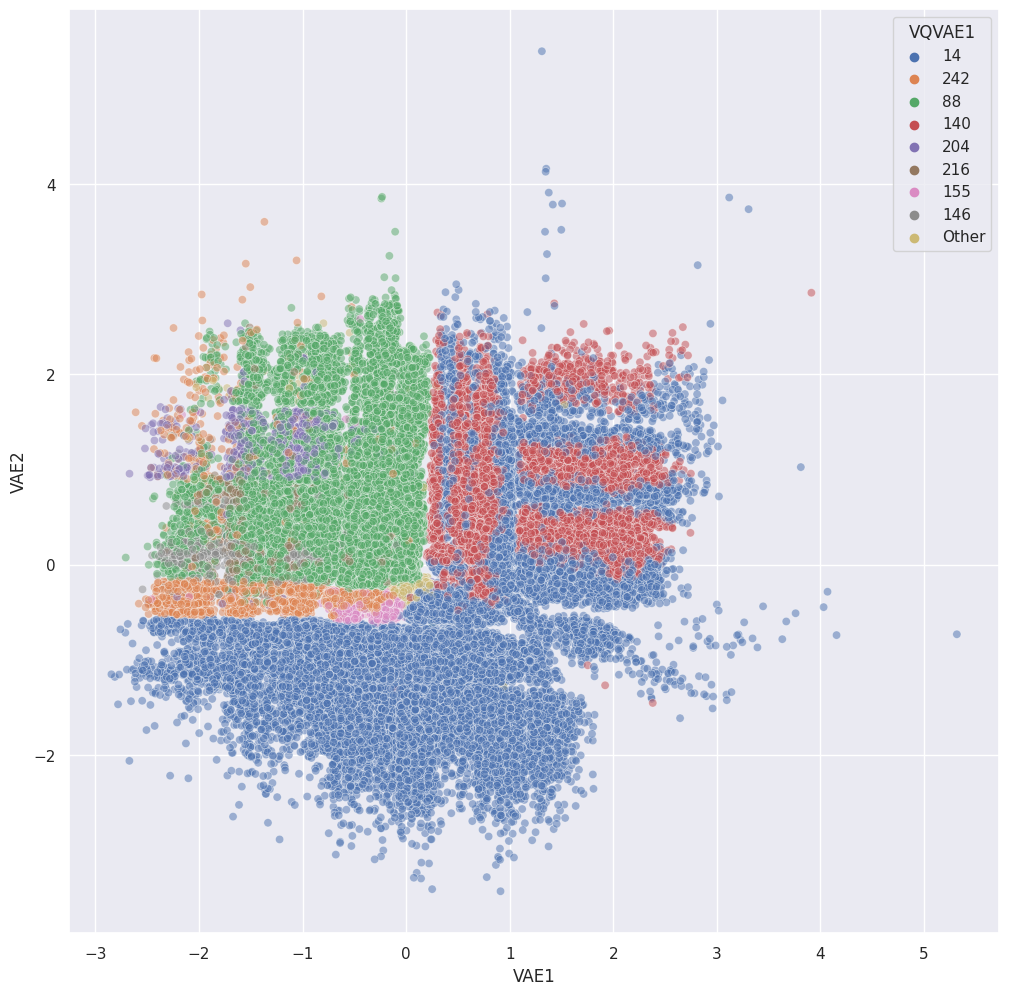

In [110]:
import seaborn as sns

dot_plot = sns.scatterplot(x="VAE1", y="VAE2",
                          data=plot_data.head(100000),
                          hue='VQVAE1',
                          legend=True,
                          alpha=0.5)

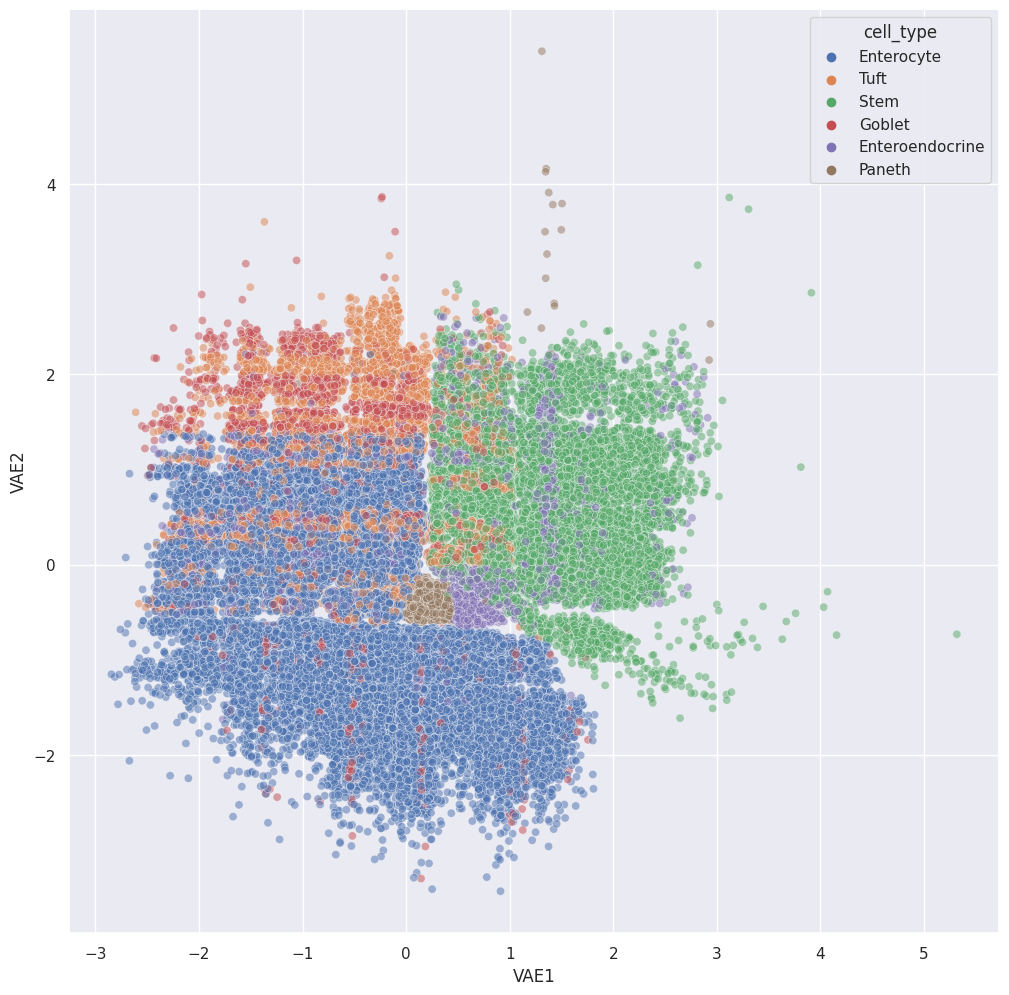

In [109]:
dot_plot = sns.scatterplot(x="VAE1", y="VAE2",
                          data=plot_data.head(100000),
                          hue='cell_type',
                          legend=True,
                          alpha=0.5)